In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bank = pd.read_excel('bank_transactions_data.xlsx')
bank.head(2)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35


In [3]:
df = bank.copy()
df.drop(columns=['PreviousTransactionDate'], inplace=True)
df.rename(columns={
    'TransactionID': 'Transaction_ID',
    'AccountID': 'Account_ID',
    'TransactionAmount': 'Transaction_Amount',
    'TransactionDate': 'Transaction_Date',
    'TransactionType': 'Transaction_Type',
    'DeviceID': 'Device_ID',
    'IP Address': 'IP_Address',
    'MerchantID': 'Merchant_ID',
    'CustomerAge': 'Customer_Age',
    'CustomerOccupation': 'Customer_Occupation',
    'TransactionDuration': 'Transaction_Duration',
    'LoginAttempts': 'Login_Attempts',
    'AccountBalance': 'Account_Balance'
}, inplace=True)

In [4]:
df.columns

Index(['Transaction_ID', 'Account_ID', 'Transaction_Amount',
       'Transaction_Date', 'Transaction_Type', 'Location', 'Device_ID',
       'IP_Address', 'Merchant_ID', 'Channel', 'Customer_Age',
       'Customer_Occupation', 'Transaction_Duration', 'Login_Attempts',
       'Account_Balance'],
      dtype='object')

### Using given metrics to determine anomaly 

In [5]:
avg_transaction = df.groupby('Account_ID')['Transaction_Amount'].transform('mean')

login = df['Login_Attempts'].apply(lambda x: 2 if x >= 4 else 0)
duration = df['Transaction_Duration'].apply(lambda x: 2 if x < 60 else 0)
transamount = df['Transaction_Amount'] > (2 * avg_transaction)
transamount = transamount.astype(int) * 3
df['Anomaly_Score'] = login + duration + transamount
df['Anomaly_Status'] = df['Anomaly_Score'].apply(lambda x: 'Suspicious' if x >= 5 else 'Legitimate')

In [6]:
df.head()

,Transaction_ID,Account_ID,Transaction_Amount,Transaction_Date,Transaction_Type,Location,Device_ID,IP_Address,Merchant_ID,Channel,Customer_Age,Customer_Occupation,Transaction_Duration,Login_Attempts,Account_Balance,Anomaly_Score,Anomaly_Status
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,0,Legitimate
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,0,Legitimate
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2,Legitimate
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2,Legitimate
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,0,Legitimate


In [7]:
df.Anomaly_Status.value_counts()

Anomaly_Status
Legitimate    2433
Suspicious      79
Name: count, dtype: int64

2023-03 had the highest Suspicious Anomaly


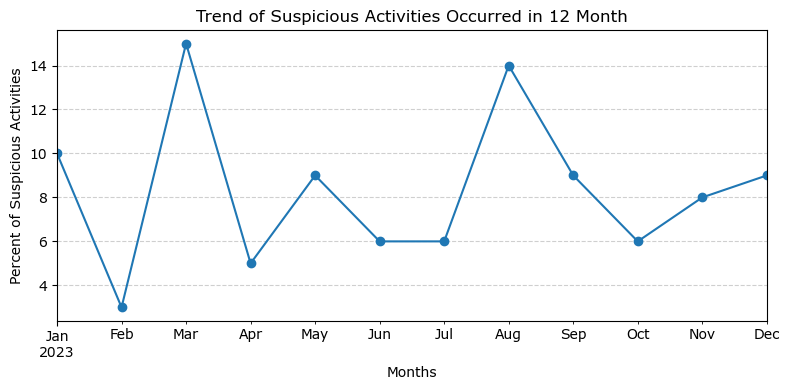

In [8]:
df['Transaction_Month'] = pd.to_datetime(df['Transaction_Date']).dt.to_period('M')
anomaly_trend = (df[df['Anomaly_Status'] == 'Suspicious'].groupby('Transaction_Month').size() * 100) / (df['Anomaly_Status'] == 'Suspicious').sum()
high_month = anomaly_trend.idxmax()
print(f'{high_month} had the highest Suspicious Anomaly')
anomaly_trend.round(0).plot(
    title='Trend of Suspicious Activities Occurred in 12 Month',
    figsize=(8,4),
    xlabel='Months',
    ylabel='Percent of Suspicious Activities',
    marker='o'
)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Possible reasons for high suspicious anomaly in March
#### login attempt >= 4
#### high value transaction > 2 * avg of transaction
#### duration < 60
#### online channel

In [9]:
filt_month_login_attempt = df[(df['Login_Attempts'] >= 4) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Transaction_Month').size()
filt_month_transaction_duration = df[(df['Transaction_Duration'] < 60) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Transaction_Month').size()
filt_month_online_channel = df[(df['Channel'] == 'Online') & (df['Anomaly_Status'] == 'Suspicious')].groupby('Transaction_Month').size()
filt_month_high_value_transaction = df[(df['Transaction_Amount'] > 2 * avg_transaction) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Transaction_Month').size()

In [10]:
print('Suspicious Login Attempts Across 12 Months')
filt_month_login_attempt

Suspicious Login Attempts Across 12 Months


Transaction_Month
2023-01    3
2023-02    1
2023-03    1
2023-08    1
2023-10    1
2023-12    2
Freq: M, dtype: int64

In [11]:
print('Suspicious Transaction Duration Across 12 Months')
filt_month_transaction_duration

Suspicious Transaction Duration Across 12 Months


Transaction_Month
2023-01     5
2023-02     1
2023-03    11
2023-04     4
2023-05     7
2023-06     5
2023-07     5
2023-08    10
2023-09     7
2023-10     4
2023-11     6
2023-12     5
Freq: M, dtype: int64

In [12]:
print('Suspicious Online Channel Across 12 Months')
filt_month_online_channel

Suspicious Online Channel Across 12 Months


Transaction_Month
2023-03    4
2023-04    2
2023-05    3
2023-06    4
2023-07    3
2023-08    5
2023-09    3
2023-10    1
2023-11    2
2023-12    2
Freq: M, dtype: int64

In [13]:
print('Suspicious High Value Transaction Across 12 Months')
filt_month_high_value_transaction

Suspicious High Value Transaction Across 12 Months


Transaction_Month
2023-01     8
2023-02     2
2023-03    12
2023-04     4
2023-05     7
2023-06     5
2023-07     5
2023-08    11
2023-09     7
2023-10     5
2023-11     6
2023-12     7
Freq: M, dtype: int64

In [14]:
matrix_corr = df.select_dtypes(include='number').corr()
matrix_corr

,Transaction_Amount,Customer_Age,Transaction_Duration,Login_Attempts,Account_Balance,Anomaly_Score
Transaction_Amount,1.000000,-0.025616,0.004359,-0.008445,-0.025165,0.460545
Customer_Age,-0.025616,1.000000,-0.017936,0.007653,0.319942,-0.022294
Transaction_Duration,0.004359,-0.017936,1.000000,0.032639,0.005577,-0.398430
Login_Attempts,-0.008445,0.007653,0.032639,1.000000,0.014999,0.186660
Account_Balance,-0.025165,0.319942,0.005577,0.014999,1.000000,-0.015681
Anomaly_Score,0.460545,-0.022294,-0.398430,0.186660,-0.015681,1.000000


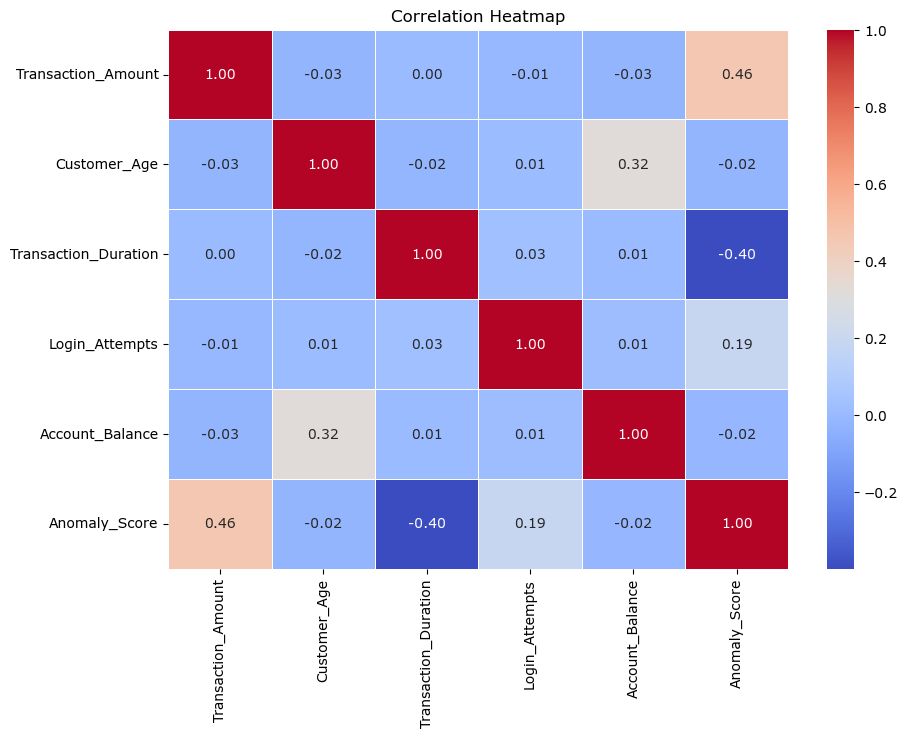

In [15]:
plt.figure(figsize=(10, 7))
sns.heatmap(matrix_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

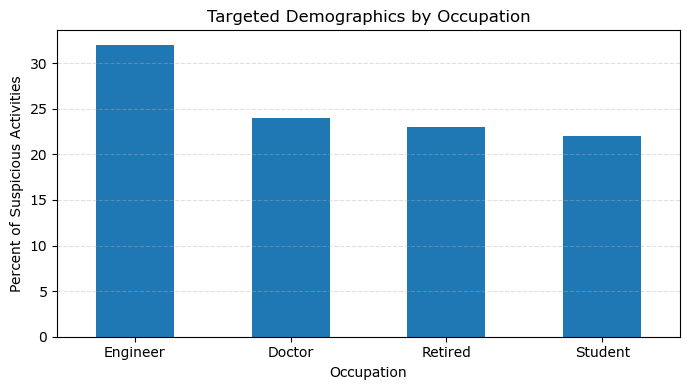

In [16]:
anomaly_occupation = (df[df['Anomaly_Status'] == 'Suspicious'].groupby('Customer_Occupation').size() * 100) / (df['Anomaly_Status'] == 'Suspicious').sum()

anomaly_occupation.sort_values(ascending=False).round(0).plot(
    kind='bar',
    title='Targeted Demographics by Occupation',
    figsize=(7,4),
    xlabel='Occupation',
    ylabel='Percent of Suspicious Activities',
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### Possible reasons for high suspicious anomaly among Engineer
#### login attempt >= 4
#### high value transaction > 2 * avg of transaction
#### duration < 60
#### online channel

In [17]:
filt_occupation_login_attempt = df[(df['Login_Attempts'] >= 4) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Customer_Occupation').size()
filt_occupation_transaction_duration = df[(df['Transaction_Duration'] < 60) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Customer_Occupation').size()
filt_occupation_online_channel = df[(df['Channel'] == 'Online') & (df['Anomaly_Status'] == 'Suspicious')].groupby('Customer_Occupation').size()
filt_occupation_high_value_transaction = df[(df['Transaction_Amount'] > 2 * avg_transaction) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Customer_Occupation').size()

In [18]:
print('Suspicious Login Attempts Amoung Occupations')
filt_occupation_login_attempt.sort_values(ascending=False)

Suspicious Login Attempts Amoung Occupations


Customer_Occupation
Engineer    4
Doctor      2
Retired     2
Student     1
dtype: int64

In [19]:
print('Suspicious Transaction Duration Amoung Occupations')
filt_occupation_transaction_duration.sort_values(ascending=False)

Suspicious Transaction Duration Amoung Occupations


Customer_Occupation
Engineer    21
Doctor      17
Retired     16
Student     16
dtype: int64

In [20]:
print('Suspicious Online Channel Usage Amoung Occupations')
filt_occupation_online_channel.sort_values(ascending=False)

Suspicious Online Channel Usage Amoung Occupations


Customer_Occupation
Doctor      9
Engineer    9
Student     6
Retired     5
dtype: int64

In [21]:
print('Suspicious High Value Transaction Amoung Occupations')
filt_occupation_high_value_transaction.sort_values(ascending=False)

Suspicious High Value Transaction Amoung Occupations


Customer_Occupation
Engineer    25
Doctor      19
Retired     18
Student     17
dtype: int64

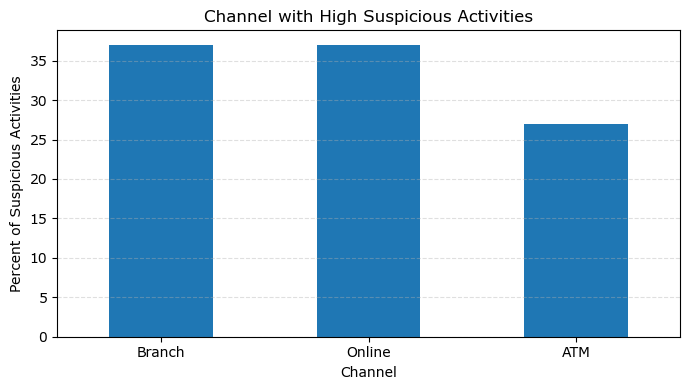

In [22]:
anomaly_channel = (df[df['Anomaly_Status'] == 'Suspicious'].groupby('Channel').size() * 100) / (df['Anomaly_Status'] == 'Suspicious').sum()

anomaly_channel.sort_values(ascending=False).round(0).plot(
    kind='bar',
    title='Channel with High Suspicious Activities',
    figsize=(7,4),
    xlabel='Channel',
    ylabel='Percent of Suspicious Activities',
)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [24]:
df.head()

,Transaction_ID,Account_ID,Transaction_Amount,Transaction_Date,Transaction_Type,Location,Device_ID,IP_Address,Merchant_ID,Channel,Customer_Age,Customer_Occupation,Transaction_Duration,Login_Attempts,Account_Balance,Anomaly_Score,Anomaly_Status,Transaction_Month
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,0,Legitimate,2023-04
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,0,Legitimate,2023-06
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2,Legitimate,2023-07
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2,Legitimate,2023-05
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,0,Legitimate,2023-10


#### Age Demographics

In [25]:
bins = [17, 25, 45, 65, 81]
labels = ['18–24', '25–44', '45–64', '65–80']
df['Age_Group'] = pd.cut(df['Customer_Age'], bins=bins, labels=labels, right=False)

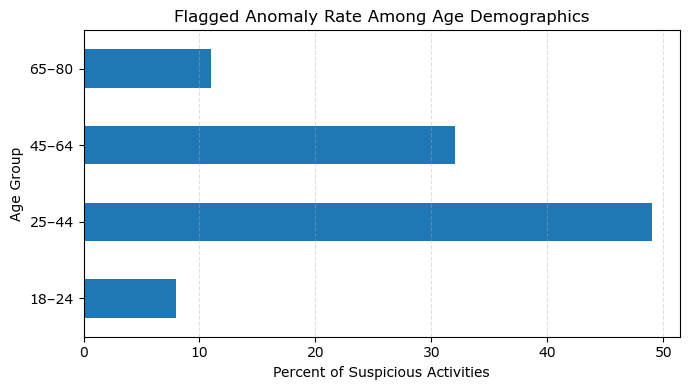

In [26]:
anomaly_age_group = (df[df['Anomaly_Status'] == 'Suspicious'].groupby('Age_Group').size() * 100) / (df['Anomaly_Status'] == 'Suspicious').sum()
anomaly_age_group.round(0).plot(
    kind='barh',
    title='Flagged Anomaly Rate Among Age Demographics',
    figsize=(7,4),
    xlabel='Percent of Suspicious Activities',
    ylabel='Age Group',
)
plt.xticks(rotation=0)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### Possible reasons for high suspicious anomaly among age group 25 - 44
#### login attempt >= 4
#### high value transaction > 2 * avg of transaction
#### duration < 60
#### online channel

In [27]:
filt_age_group_login_attempt = df[(df['Login_Attempts'] >= 4) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Age_Group').size()
filt_age_group_transaction_duration = df[(df['Transaction_Duration'] < 60) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Age_Group').size()
filt_age_group_online_channel = df[(df['Channel'] == 'Online') & (df['Anomaly_Status'] == 'Suspicious')].groupby('Age_Group').size()
filt_age_group_high_value_transaction = df[(df['Transaction_Amount'] > 2 * avg_transaction) & (df['Anomaly_Status'] == 'Suspicious')].groupby('Age_Group').size()

In [28]:
print('Suspicious Login Attempts Amoung Age Group')
filt_age_group_login_attempt

Suspicious Login Attempts Amoung Age Group


Age_Group
18–24    1
25–44    3
45–64    5
65–80    0
dtype: int64

In [29]:
print('Suspicious Transaction Duration Amoung Age Group')
filt_age_group_transaction_duration

Suspicious Transaction Duration Amoung Age Group


Age_Group
18–24     5
25–44    36
45–64    20
65–80     9
dtype: int64

In [30]:
print('Suspicious Online Channel Usage Amoung Age Group')
filt_age_group_online_channel

Suspicious Online Channel Usage Amoung Age Group


Age_Group
18–24     4
25–44    16
45–64     6
65–80     3
dtype: int64

In [31]:
print('Suspicious High Value Transaction Amoung Age Group')
filt_age_group_high_value_transaction

Suspicious High Value Transaction Amoung Age Group


Age_Group
18–24     6
25–44    39
45–64    25
65–80     9
dtype: int64

### Preferred Channel Among Age Groups

In [32]:
age_group_channel = df.pivot_table(index='Age_Group', columns='Channel', aggfunc='size', fill_value=0)
age_group_channel = age_group_channel.div(age_group_channel.sum(axis=1), axis=0) * 100
age_group_channel.round(1)

Channel,ATM,Branch,Online
Age_Group,,,
18–24,34.3,34.3,31.3
25–44,30.9,34.9,34.2
45–64,35.2,35.1,29.7
65–80,32.3,32.8,34.8


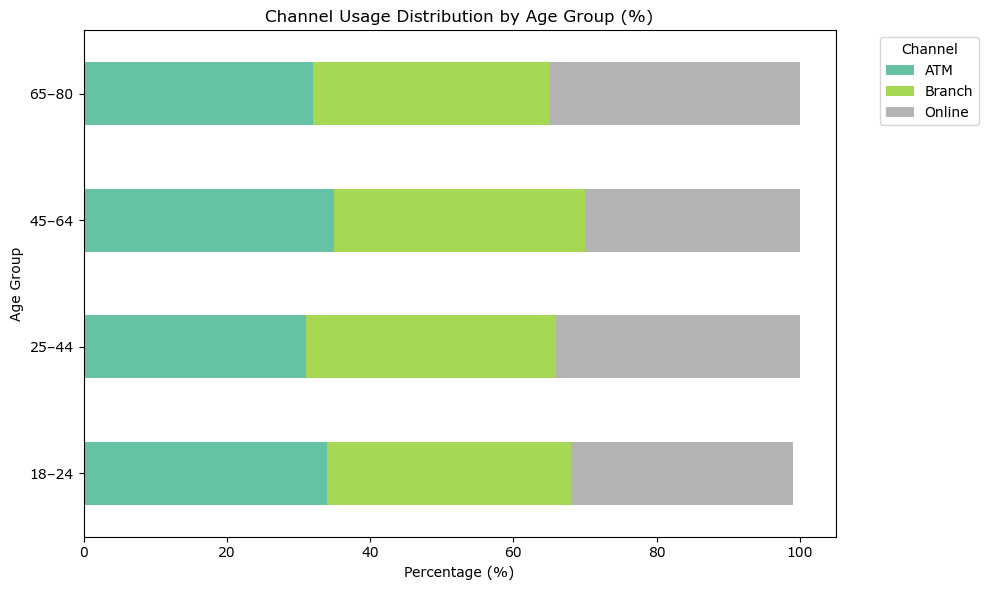

In [33]:
age_group_channel.round().plot(
kind='barh',
    stacked=True,
    figsize=(10, 6),
    colormap='Set2'
)

plt.xlabel('Percentage (%)')
plt.ylabel('Age Group')
plt.title('Channel Usage Distribution by Age Group (%)')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')  # Moves legend outside
plt.tight_layout()

plt.show()

In [34]:
age_group_channel = df.pivot_table(
    index='Age_Group',
    columns='Channel',
    aggfunc='size',
    fill_value=0
)

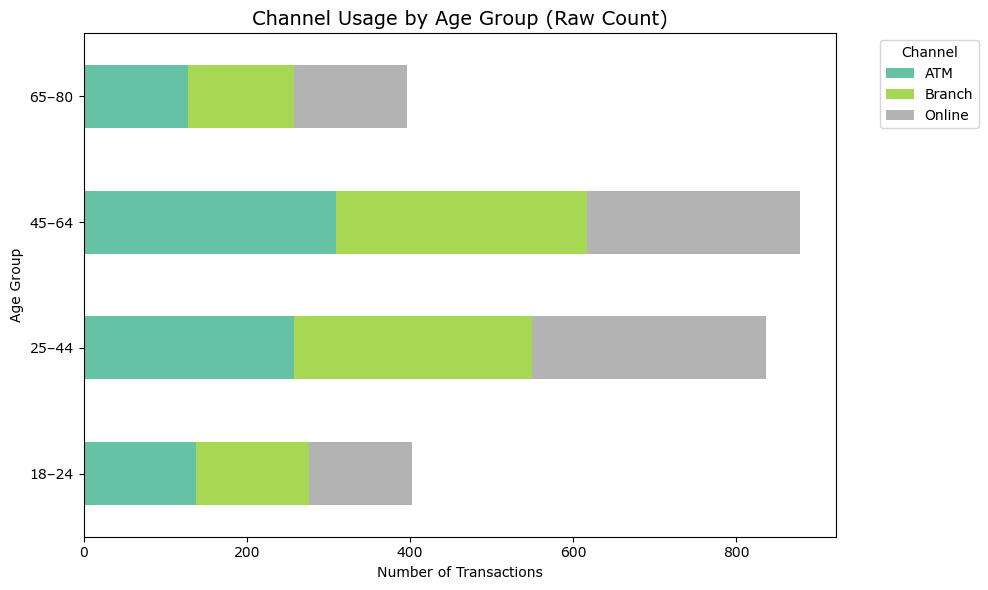

In [35]:
ax = age_group_channel.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    colormap='Set2'
)
plt.title('Channel Usage by Age Group (Raw Count)', fontsize=14)
plt.xlabel('Number of Transactions')
plt.ylabel('Age Group')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

### Extra 

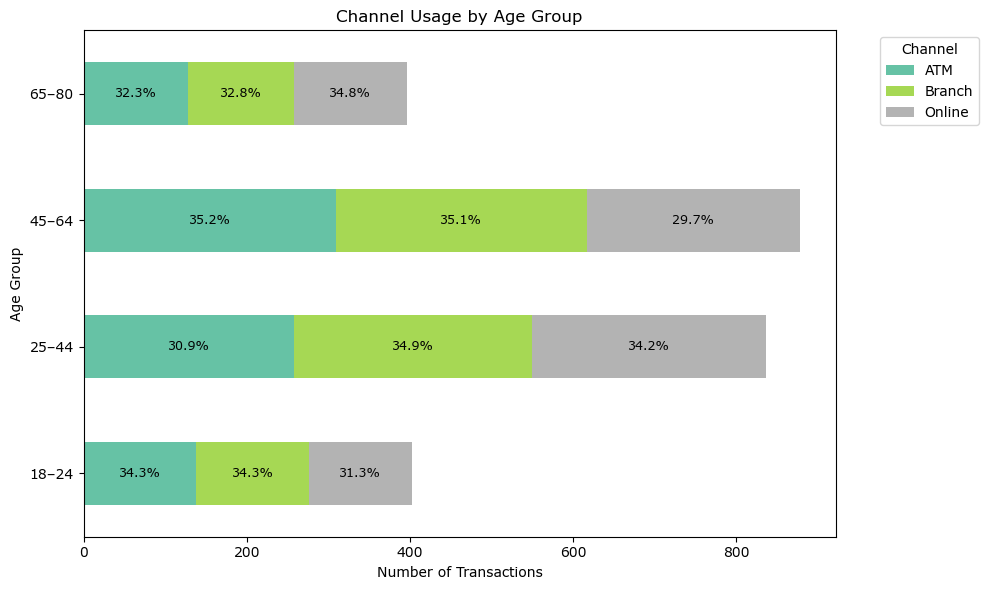

In [36]:
age_group_channel = df.pivot_table(
    index='Age_Group',
    columns='Channel',
    aggfunc='size',
    fill_value=0
)

fig, ax = plt.subplots(figsize=(10, 6))
age_group_channel.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    colormap='Set2'
)

total_per_row = age_group_channel.sum(axis=1)

for i, (index, row) in enumerate(age_group_channel.iterrows()):
    cumulative = 0
    for col in age_group_channel.columns:
        value = row[col]
        if value > 0:
            percent = (value / total_per_row[index]) * 100
            ax.text(
                x=cumulative + value / 2, 
                y=i,                      
                s=f'{percent:.1f}%',  
                ha='center',
                va='center',
                fontsize=9,
                color='black'
            )
            cumulative += value

ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Age Group')
ax.set_title('Channel Usage by Age Group')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()